In [2]:
import numpy as np
import polars as pl
import pandas as pd
from scipy.stats import mstats
import pandas_market_calendars as mcal

# adr_df = pd.read_csv('../data/processed/adr_mids_at_underlying_close_adjust_none.csv', index_col=0, parse_dates=True)
# under_df = pd.read_csv('../data/processed/brit_underlying_close_to_usd_adr_PX_MID_adjust_none.csv', index_col=0, parse_dates=True)

# holdings_filename = '../notebooks/brit_exchange_traded_efa_adrs_detailed.csv'
# hold_df = pd.read_csv(holdings_filename)

# adr_dict = hold_df[['id','adr']].set_index('id')['adr'].str.replace(' US Equity', '').to_dict()
# under_df = under_df.rename(columns=adr_dict)

# prem_df = ((adr_df.div(under_df)).dropna(axis=0, how='all')-1)*1e4

def winsorize_df(df, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorize all numeric columns in a DataFrame independently."""
    lower = df.quantile(lower_quantile)
    upper = df.quantile(upper_quantile)
    df = df.clip(lower, upper)

    return df

In [3]:
adr_df = pd.read_csv('../data/processed/adr_mid_at_underlying_auction_adjust_all.csv', index_col=0, parse_dates=True)
under_df = pd.read_csv('../data/processed/brit_underlying_close_to_usd_adr_PX_LAST_adjust_all.csv', index_col=0, parse_dates=True)

holdings_filename = '../notebooks/brit_exchange_traded_efa_adrs_detailed.csv'
hold_df = pd.read_csv(holdings_filename)

adr_dict = hold_df[['id','adr']].set_index('id')['adr'].str.replace(' US Equity', '').to_dict()
under_df = under_df.rename(columns=adr_dict)

adj_prem_df = np.log((adr_df.div(under_df)).dropna(axis=0, how='all')).loc['2020':]
expected_return = np.exp(adj_prem_df.ewm(halflife=5).mean() - adj_prem_df) - 1

In [ ]:
start_date = adj_prem_df.index.min().date()
end_date = adj_prem_df.index.max().date()

exchanges = hold_df['exchange'].unique().tolist()
close_time = pd.DataFrame({ex: mcal.get_calendar(ex).schedule(start_date=start_date, end_date=end_date)['market_close'].dt.tz_convert('America/New_York') for ex in exchanges})
close_time['XLON'] += pd.Timedelta(hours=0, minutes=5)  # London auction time 5 minutes after close
close_time = close_time.stack().reset_index(name='close_time').rename(columns={'level_0':'date','level_1':'exchange'})
ticker_close = hold_df[['adr','exchange']].merge(close_time, on='exchange')
ticker_close['ticker'] = ticker_close['adr'].str.replace(' US Equity', '')

next_close_time = pd.DataFrame({ex: mcal.get_calendar(ex).schedule(start_date=start_date, end_date=end_date)['market_close'].dt.tz_convert('America/New_York').shift(-1) for ex in exchanges})
next_close_time = next_close_time.stack().reset_index(name='close_time').rename(columns={'level_0':'date','level_1':'exchange'})
next_ticker_close = hold_df[['adr','exchange']].merge(next_close_time, on='exchange')
next_ticker_close['ticker'] = next_ticker_close['adr'].str.replace(' US Equity', '')

ny_close = mcal.get_calendar('NYSE').schedule(start_date=start_date, end_date=end_date)['market_close'].dt.tz_convert('America/New_York')
ny_next_open = mcal.get_calendar('NYSE').schedule(start_date=start_date, end_date=end_date)['market_open'].dt.tz_convert('America/New_York').shift(-1)

In [5]:
# import matplotlib.pyplot as plt
# adr_tickers = hold_df['adr'].str.replace(' US Equity', '').unique().tolist()
# for adr_ticker in adr_tickers:
#     # Only read the columns we need to avoid schema conflicts
#     adr_data = pd.read_parquet(
#         f'../data/raw/adrs/bbo-1m/nbbo/ticker={adr_ticker}',
#         columns=['nbbo_bid', 'nbbo_ask', 'Ticker' ,'date']
#     )

#     # Create mid column
#     adr_data['mid'] = (adr_data['nbbo_bid'] + adr_data['nbbo_ask']) / 2

#     # Select only necessary columns
#     adr_data = adr_data[['mid', 'date','Ticker']]
#     adr_data['date'] = adr_data['date'].astype('datetime64[ns]')
#     adr_data = adr_data.reset_index()

#     merged_under_close = adr_data.merge(ticker_close, left_on=['Ticker', 'date'], right_on=['ticker','date'], how='left')
#     under_close = merged_under_close[merged_under_close['ts_recv'] == merged_under_close['close_time']].set_index('date')['mid']

#     merged_ny_close = adr_data.merge(ny_close, left_on='date', right_index=True, how='left')
#     ny_close_mid = merged_ny_close[merged_ny_close['ts_recv'] == merged_ny_close['market_close']].set_index('date')['mid']

#     merged_next_close = adr_data.merge(next_ticker_close, left_on=['Ticker', 'date'], right_on=['ticker','date'], how='left')
#     next_under_close = merged_next_close[merged_next_close['ts_recv'] == merged_next_close['close_time']].set_index('date')['mid']

#     ret = (ny_close_mid - under_close)/under_close
#     ret_data = pd.merge(expected_return[adr_ticker].rename('expected_return'), ret.rename('realized_return'), left_index=True, right_index=True)
#     plt.figure()
#     ret_data.plot('expected_return', 'realized_return', kind='scatter')

#     ic = ret_data['expected_return'].corr(ret_data['realized_return'])
#     plt.title(f'{adr_ticker} (r = {ic:.3f})')

In [ ]:
import matplotlib.pyplot as plt
adr_tickers = hold_df['adr'].str.replace(' US Equity', '').unique().tolist()
all_ny_ic = []
all_london_ic = []

all_ny_res = []
all_london_res = []

for adr_ticker in adr_tickers:
    # Only read the columns we need to avoid schema conflicts
    adr_data = pd.read_parquet(
        f'../../intraday_mean_reversion/data/raw/adrs/bbo-1m/nbbo/ticker={adr_ticker}',
        columns=['nbbo_bid', 'nbbo_ask', 'Ticker' ,'date']
    )
    # Create mid column
    adr_data['mid'] = (adr_data['nbbo_bid'] + adr_data['nbbo_ask']) / 2

    # Select only necessary columns
    adr_data = adr_data[['mid', 'date','Ticker']]
    adr_data['date'] = adr_data['date'].astype('datetime64[ns]')
    adr_data = adr_data.reset_index()

    merged_under_close = adr_data.merge(ticker_close, left_on=['Ticker', 'date'], right_on=['ticker','date'], how='left')
    under_close = merged_under_close[merged_under_close['ts_recv'] == merged_under_close['close_time']].set_index('date')['mid']

    merged_ny_close = adr_data.merge(ny_close, left_on='date', right_index=True, how='left')
    ny_close_mid = merged_ny_close[merged_ny_close['ts_recv'] == merged_ny_close['market_close']].set_index('date')['mid']

    next_under_close = under_close.shift(-1)

    ret = (ny_close_mid - under_close)/under_close
    ret_data = pd.merge(expected_return[adr_ticker].rename('expected_return'), ret.rename('realized_return'), left_index=True, right_index=True)
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(1,2,1)
    ret_data.plot('expected_return', 'realized_return', kind='scatter', ax=ax)
    ic = ret_data['expected_return'].corr(ret_data['realized_return'])
    all_ny_ic.append(ic)
    plt.xticks(rotation=45)
    plt.title(f'{adr_ticker} (r = {ic:.3f}) NY Close')


    next_ret = (next_under_close - under_close)/under_close
    next_ret_data = pd.merge(expected_return[adr_ticker].rename('expected_return'), next_ret.rename('realized_return'), left_index=True, right_index=True)
    ax = plt.subplot(1,2,2)
    next_ret_data.plot('expected_return', 'realized_return', kind='scatter', ax=ax)
    

    ic = next_ret_data['expected_return'].corr(next_ret_data['realized_return'])
    all_london_ic.append(ic)
    plt.xticks(rotation=45)
    plt.title(f'{adr_ticker} (r = {ic:.3f}) Next London Close')

In [ ]:
import pandas as pd

etf_tickers = pd.read_csv('../data/raw/hedges.csv')['hedge'].dropna().unique().tolist()
all_etf_dfs = []
hedge_dict = pd.read_csv('../data/raw/hedges.csv').set_index('adr')['hedge'].to_dict()
ticker_close['hedge'] = ticker_close['ticker'].map(hedge_dict)

for ticker in etf_tickers:
    etf_df = pd.read_parquet(f'../../intraday_mean_reversion/data/raw/adr_hedges/bbo-1m/nbbo/ticker={ticker}')
    etf_df['date'] = etf_df['date'].astype('datetime64[ns]')
    etf_df['exchange'] = 'XLON'
    etf_df = etf_df.reset_index().rename(columns={'ts_recv':'timestamp'})
)
    merged_etf = ny_close.rename('ny_close').reset_index().rename(columns={'index':'date'}).merge(merged_etf, on=['date'])
    merged_etf = merged_etf.rename(columns={'close_time':'under_close'})
    merged_etf['mid'] = (merged_etf['nbbo_bid'] + merged_etf['nbbo_ask']) / 2
    merged_etf = merged_etf[['timestamp','date','ticker','mid','under_close','ny_close']]
    all_etf_dfs.append(merged_etf)
    print(f'Processed ETF ticker: {ticker}')
    del etf_df

merged_etf = pd.concat(all_etf_dfs)

Processed ETF ticker: PPH
Processed ETF ticker: EUFN
Processed ETF ticker: XLP
Processed ETF ticker: XLE
Processed ETF ticker: XLY
Processed ETF ticker: IFRA
Processed ETF ticker: XLC
Processed ETF ticker: PICK
Processed ETF ticker: IHI


In [ ]:
hedge_ticker = 'EWU'
hedge_df = pd.read_parquet(f'../../intraday_mean_reversion/data/raw/adr_hedges/bbo-1m/nbbo/ticker={hedge_ticker}', columns=['ts_recv','nbbo_bid','nbbo_ask','date'])
hedge_df['date'] = hedge_df['date'].astype('datetime64[ns]')
hedge_df['exchange'] = 'XLON'
hedge_df = hedge_df.reset_index().rename(columns={'ts_recv':'timestamp'})

merged_hedge = close_time.merge(hedge_df, on=['exchange', 'date'])
merged_hedge = ny_close.rename('ny_close').reset_index().rename(columns={'index':'date'}).merge(merged_hedge, on=['date'])
merged_hedge = merged_hedge.rename(columns={'close_time':'under_close'})
merged_hedge['mid'] = (merged_hedge['nbbo_bid'] + merged_hedge['nbbo_ask']) / 2
merged_hedge = merged_hedge[['timestamp','date','mid','under_close','ny_close']]

In [ ]:
futures_df = pd.read_parquet('../data/processed/FTUK_close_to_usd_1min.parquet')
futures_df['exchange'] = 'XLON'

futures_df['date'] = futures_df['timestamp'].dt.tz_localize(None).dt.normalize()
merged_futures = ticker_close.merge(futures_df, on=['exchange', 'date'])
merged_futures = ny_close.rename('ny_close').reset_index().rename(columns={'index':'date'}).merge(merged_futures, on=['date'])
merged_futures = merged_futures.rename(columns={'close_time':'under_close'})

In [ ]:
import xarray as xr

signal_betas = xr.open_dataarray('../data/processed/brit_underlying_betas_to_UKX_and_sector.nc')
hedge_betas = pd.read_csv('../data/processed/adr_EWU_betas.csv', index_col=0, parse_dates=True)
def get_predicted_returns(fut_intraday_ret, etf_intraday_ret, betas):
    # betas.index.name = 'date'
    # betas.columns.name = 'ticker'

    merged_df = pd.merge(fut_intraday_ret.stack().to_frame('future_returns'), 
                        etf_intraday_ret.stack().to_frame('etf_returns'),
                        on=['date','ticker'])
    merged_df = pd.merge(merged_df, betas.loc[:,:,'market_beta'].to_pandas().stack().to_frame('market_beta'), on=['date','ticker'])
    merged_df = pd.merge(merged_df, betas.loc[:,:,'sector_beta'].to_pandas().stack().to_frame('sector_beta'), on=['date','ticker'])
    merged_df['predicted_return'] = merged_df['market_beta'] * merged_df['future_returns'] + merged_df['sector_beta'].fillna(0) * merged_df['etf_returns']
    pred = merged_df['predicted_return'].unstack()

    return pred

In [ ]:
futures_under_close = merged_futures[merged_futures['timestamp'] == merged_futures['under_close']].pivot(index='date', columns='ticker', values='close')
futures_ny_close = merged_futures.groupby(['date', 'ticker'])['close'].last().unstack()
fut_intraday_ret = (futures_ny_close - futures_under_close) / futures_under_close

In [ ]:
etf_under_close = merged_etf[merged_etf['timestamp'] == merged_etf['under_close']].pivot(index='date', columns='ticker', values='mid')
etf_ny_close = merged_etf.groupby(['date', 'ticker'])['mid'].last().unstack()
etf_intraday_ret = (etf_ny_close - etf_under_close) / etf_under_close

In [ ]:
t0_delta = pd.Timedelta(hours=0, minutes=30)
merged_hedge['t0'] = (merged_hedge['under_close'] + t0_delta)
hedge_under_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['under_close']].set_index('date')['mid']
hedge_t0 = merged_hedge[merged_hedge['timestamp'] == merged_hedge['t0']].set_index('date')['mid']
hedge_ny_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['ny_close']].set_index('date')['mid']
next_hedge_under_close = hedge_under_close.shift(-1)
hedge_ret = (hedge_ny_close - hedge_t0) / hedge_t0

In [ ]:
import datetime as dt
import matplotlib.pyplot as plt

adr_tickers = hold_df['adr'].str.replace(' US Equity', '').unique().tolist()
filtered_adr_tickers = [ticker for ticker in adr_tickers if ticker not in ['PSO','RTO','VOD']]

all_ny_ic = {t:[] for t in filtered_adr_tickers}
all_next_london_ic = {t:[] for t in filtered_adr_tickers}

t0_deltas = [
                pd.Timedelta(hours=0, minutes=0),
                pd.Timedelta(hours=0, minutes=1),
                pd.Timedelta(hours=0, minutes=2),
                pd.Timedelta(hours=0, minutes=3),
                pd.Timedelta(hours=0, minutes=4),
                pd.Timedelta(hours=0, minutes=5), 
                pd.Timedelta(hours=0, minutes=10),
                pd.Timedelta(hours=0, minutes=15), 
                pd.Timedelta(hours=0, minutes=20),
                pd.Timedelta(hours=0, minutes=30),
                pd.Timedelta(hours=1, minutes=0),
                pd.Timedelta(hours=1, minutes=30),
                pd.Timedelta(hours=2, minutes=0),
                pd.Timedelta(hours=2, minutes=30),
                pd.Timedelta(hours=3, minutes=0),
            ]

#t0_delta = pd.Timedelta(hours=0, minutes=1)
for t0_delta in t0_deltas:
    merged_futures['t0'] = (merged_futures['under_close'] + t0_delta)
    futures_under_close = merged_futures[merged_futures['timestamp'] == merged_futures['under_close']].pivot(index='date', columns='ticker', values='close')
    futures_t0 = merged_futures[merged_futures['timestamp'] == merged_futures['t0']].pivot(index='date', columns='ticker', values='close')
    fut_ret = (futures_t0 - futures_under_close) / futures_under_close

    merged_etf['t0'] = (merged_etf['under_close'] + t0_delta)
    etf_under_close = merged_etf[merged_etf['timestamp'] == merged_etf['under_close']].pivot(index='date', columns='ticker', values='mid')
    etf_t0 = merged_etf[merged_etf['timestamp'] == merged_etf['t0']].pivot(index='date', columns='ticker', values='mid')
    etf_intraday_ret = (etf_t0 - etf_under_close) / etf_under_close

    merged_hedge['t0'] = (merged_hedge['under_close'] + t0_delta)
    hedge_under_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['under_close']].set_index('date')['mid']
    hedge_t0 = merged_hedge[merged_hedge['timestamp'] == merged_hedge['t0']].set_index('date')['mid']
    hedge_ny_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['ny_close']].set_index('date')['mid']
    next_hedge_under_close = hedge_under_close.shift(-1)
    hedge_ret = (hedge_ny_close - hedge_t0) / hedge_t0
    next_hedge_ret = (next_hedge_under_close - hedge_t0) / hedge_t0

    pred_underlying_ret = get_predicted_returns(fut_ret, etf_intraday_ret, signal_betas)

    for adr_ticker in filtered_adr_tickers:
        # Only read the columns we need to avoid schema conflicts
        adr_data = pd.read_parquet(
            f'../../intraday_mean_reversion/data/raw/adrs/bbo-1m/nbbo/ticker={adr_ticker}',
            columns=['nbbo_bid', 'nbbo_ask', 'Ticker' ,'date']
        )
        # Create mid column
        adr_data['mid'] = (adr_data['nbbo_bid'] + adr_data['nbbo_ask']) / 2

        # Select only necessary columns
        adr_data = adr_data[['mid', 'date','Ticker']]
        adr_data['date'] = adr_data['date'].astype('datetime64[ns]')
        adr_data = adr_data.reset_index()

        # getting adr at various times
        merged_under_close = adr_data.merge(ticker_close, left_on=['Ticker', 'date'], right_on=['ticker','date'], how='left')
        under_close = merged_under_close[merged_under_close['ts_recv'] == merged_under_close['close_time']].set_index('date')['mid']
        t0_adr = merged_under_close[merged_under_close['ts_recv'] == (merged_under_close['close_time'] + t0_delta)].set_index('date')['mid']

        merged_ny_close = adr_data.merge(ny_close, left_on='date', right_index=True, how='left')
        ny_close_mid = merged_ny_close[merged_ny_close['ts_recv'] == merged_ny_close['market_close']].set_index('date')['mid']
        next_under_close = under_close.shift(-1)

        # getting hedge return
        hedge_data = pd.merge(hedge_betas[adr_ticker].rename('hedge_beta'), hedge_ret.rename('hedge_return'), left_index=True, right_index=True)
        hedge_data = pd.merge(hedge_data, next_hedge_ret.rename('next_hedge_return'), left_index=True, right_index=True)
        ticker_hedge_ret = hedge_data['hedge_return'] * hedge_data['hedge_beta']
        ticker_hedge_next_ret = hedge_data['next_hedge_return'] * hedge_data['hedge_beta']

        # getting futures returns between underlying close and t0
        real_ret = (ny_close_mid - t0_adr)/t0_adr - ticker_hedge_ret
        past_ret = (t0_adr - under_close)/under_close
        next_ret = (next_under_close - t0_adr)/t0_adr - ticker_hedge_next_ret
    
        ret_data = pd.merge(expected_return[adr_ticker].rename('expected_return'), real_ret.rename('realized_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, pred_underlying_ret[adr_ticker].rename('systematic_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, past_ret.rename('past_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, next_ret.rename('next_return'), left_index=True, right_index=True)

        ret_data['expected_return'] = ret_data['systematic_return'] - ret_data['past_return'] # - ret_data['past_return'] + ret_data['systematic_return'] ret_data['expected_return'] + 
        ret_data = ret_data[ret_data['expected_return'].abs() < 0.01]
        #ret_data = winsorize_df(ret_data, lower_quantile=0.01, upper_quantile=0.99)

        # plt.figure(figsize=(12,4))
        # ax = plt.subplot(1,2,1)
        # ret_data.plot('expected_return', 'realized_return', kind='scatter', ax=ax)
        ic = ret_data['expected_return'].corr(ret_data['realized_return'])
        all_ny_ic[adr_ticker].append(ic)
        
        # plt.xticks(rotation=45)
        # plt.title(f'{adr_ticker} (r = {ic:.3f}) NY Close')

        # ax = plt.subplot(1,2,2)
        # ret_data.plot('expected_return', 'next_return', kind='scatter', ax=ax)

        ic = ret_data['expected_return'].corr(ret_data['next_return'])
        all_next_london_ic[adr_ticker].append(ic)
        # plt.xticks(rotation=45)
        # plt.title(f'{adr_ticker} (r = {ic:.3f}) Next London Close')

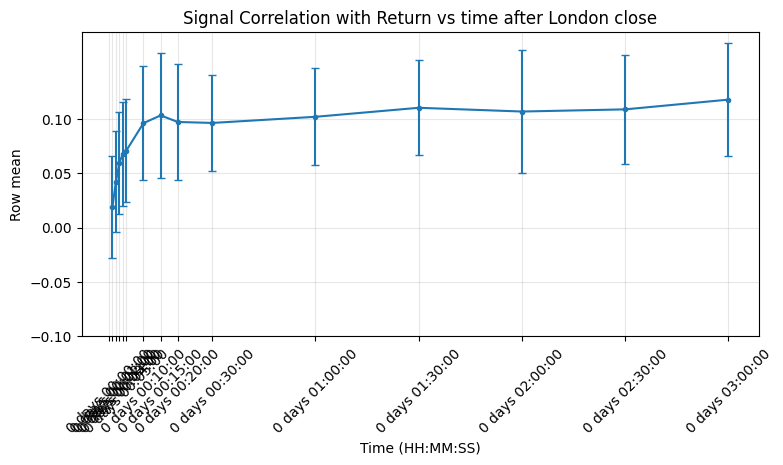

In [ ]:
import seaborn as sns

df = pd.DataFrame(all_ny_ic)
df.index = t0_deltas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):
assert isinstance(df.index, pd.TimedeltaIndex), "Index must be a TimedeltaIndex"

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()


In [ ]:
df_hedged = df
df_none = pd.read_csv('no_sector_results.csv', index_col=0)

,AZN,BCS,BTI,BP,DEO,GSK,HLN,HSBC,IHG,LYG,NGG,NWG,RELX,RIO,SHEL,SNN,UL,WPP
0 days 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0 days 00:01:00,0.022319,-0.023939,0.025270,-0.040705,0.030687,-0.034880,0.020037,-0.035226,0.080790,-0.002605,0.062508,-0.035481,0.045002,-0.041446,-0.037230,-0.002711,0.014957,0.137927
0 days 00:02:00,0.008120,0.043292,0.027876,-0.014792,0.014772,0.009337,0.011487,0.009420,0.096839,0.055935,0.082252,0.050594,0.042097,-0.056865,0.005950,0.027794,0.046700,0.143049
0 days 00:03:00,0.025096,0.075610,0.056047,0.016876,0.061367,0.005891,0.025080,0.025250,0.130219,0.062155,0.086330,0.104942,0.057277,-0.052271,-0.011629,0.048950,0.084852,0.141468
0 days 00:04:00,0.039618,0.087780,0.041530,0.019093,0.087755,-0.024788,0.035910,0.054981,0.120415,0.069294,0.092275,0.086003,0.102135,-0.028796,0.009683,0.057416,0.086435,0.152382
0 days 00:05:00,0.050790,0.095431,0.031250,0.029078,0.073843,-0.022131,0.047129,0.043752,0.136494,0.096795,0.070884,0.089351,0.127662,-0.024327,0.035459,0.062522,0.086679,0.148689
0 days 00:10:00,0.056960,0.118210,0.129009,0.048663,0.094653,-0.029475,0.121628,0.096655,0.167453,0.121295,0.121298,0.135143,0.114326,0.037200,0.086553,0.055855,0.095782,0.155871
0 days 00:15:00,0.064027,0.107483,0.111914,0.032302,0.073966,-0.028629,0.158330,0.110287,0.163137,0.149348,0.165339,0.152843,0.121814,0.076080,0.087613,0.068516,0.097687,0.158478
0 days 00:20:00,0.064869,0.145619,0.120194,0.028750,0.103394,0.009194,0.098285,0.118809,0.156021,0.160221,0.120341,0.164444,0.068742,0.072071,0.055282,0.056247,0.083476,0.154320
0 days 00:30:00,0.076705,0.138116,0.093824,0.050853,0.084601,0.037010,0.131433,0.111750,0.131277,0.171568,0.095825,0.170052,0.053173,0.082611,0.078382,0.014994,0.086143,0.151640


In [ ]:
merged = pd.merge(df_none.iloc[10].rename('no_sector_hedge'), df_hedged.iloc[10].rename('with_sector_hedge'), left_index=True, right_index=True)
merged.diff(axis=1).iloc[:,1].sort_values()

BCS    -0.015563
NGG    -0.012075
BP     -0.006399
LYG    -0.004002
WPP    -0.002660
IHG     0.000033
RIO     0.000627
SNN     0.002676
HLN     0.002867
NWG     0.004161
RELX    0.006989
DEO     0.007196
HSBC    0.011763
AZN     0.013885
SHEL    0.021967
BTI     0.024365
UL      0.024774
GSK     0.052972
Name: with_sector_hedge, dtype: float64

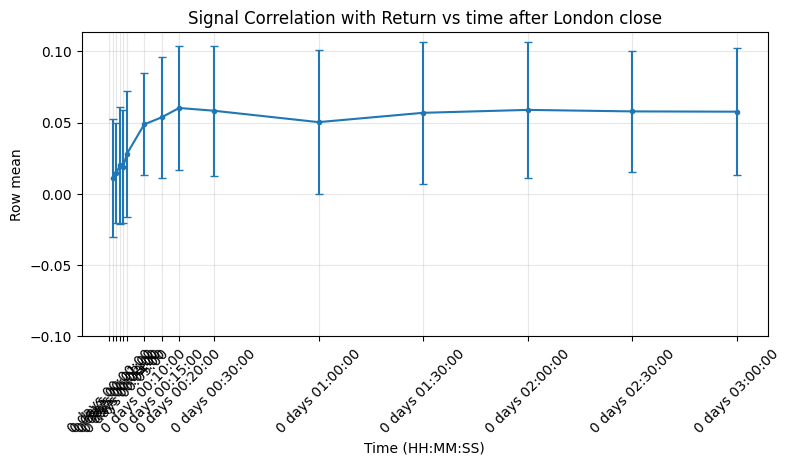

In [36]:
import seaborn as sns

df = pd.DataFrame(all_next_london_ic)
df.index = t0_deltas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):
assert isinstance(df.index, pd.TimedeltaIndex), "Index must be a TimedeltaIndex"

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()

In [33]:
import datetime as dt
import matplotlib.pyplot as plt

adr_tickers = hold_df['adr'].str.replace(' US Equity', '').unique().tolist()
filtered_adr_tickers = [ticker for ticker in adr_tickers if ticker not in ['PSO','RTO','VOD']]

all_ny_ic = {t:[] for t in filtered_adr_tickers}
all_next_london_ic = {t:[] for t in filtered_adr_tickers}

t0_deltas = [
                pd.Timedelta(hours=0, minutes=0),
                pd.Timedelta(hours=0, minutes=1),
                pd.Timedelta(hours=0, minutes=2),
                pd.Timedelta(hours=0, minutes=3),
                pd.Timedelta(hours=0, minutes=4),
                pd.Timedelta(hours=0, minutes=5), 
                pd.Timedelta(hours=0, minutes=10),
                pd.Timedelta(hours=0, minutes=15), 
                pd.Timedelta(hours=0, minutes=20),
                pd.Timedelta(hours=0, minutes=30),
                pd.Timedelta(hours=1, minutes=0),
                pd.Timedelta(hours=1, minutes=30),
                pd.Timedelta(hours=2, minutes=0),
                pd.Timedelta(hours=2, minutes=30),
                pd.Timedelta(hours=3, minutes=0),
            ]

#t0_delta = pd.Timedelta(hours=0, minutes=1)
for t0_delta in t0_deltas:
    merged_futures['t0'] = (merged_futures['under_close'] + t0_delta)
    futures_under_close = merged_futures[merged_futures['timestamp'] == merged_futures['under_close']].pivot(index='date', columns='ticker', values='close')
    futures_t0 = merged_futures[merged_futures['timestamp'] == merged_futures['t0']].pivot(index='date', columns='ticker', values='close')
    fut_ret = (futures_t0 - futures_under_close) / futures_under_close

    merged_etf['t0'] = (merged_etf['under_close'] + t0_delta)
    etf_under_close = merged_etf[merged_etf['timestamp'] == merged_etf['under_close']].pivot(index='date', columns='ticker', values='mid')
    etf_t0 = merged_etf[merged_etf['timestamp'] == merged_etf['t0']].pivot(index='date', columns='ticker', values='mid')
    etf_intraday_ret = (etf_t0 - etf_under_close) / etf_under_close

    merged_hedge['t0'] = (merged_hedge['under_close'] + t0_delta)
    hedge_under_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['under_close']].set_index('date')['mid']
    hedge_t0 = merged_hedge[merged_hedge['timestamp'] == merged_hedge['t0']].set_index('date')['mid']
    hedge_ny_close = merged_hedge[merged_hedge['timestamp'] == merged_hedge['ny_close']].set_index('date')['mid']
    next_hedge_under_close = hedge_under_close.shift(-1)
    hedge_ret = (hedge_ny_close - hedge_t0) / hedge_t0
    next_hedge_ret = (next_hedge_under_close - hedge_t0) / hedge_t0

    pred_underlying_ret = get_predicted_returns(fut_ret, etf_intraday_ret, signal_betas)

    for adr_ticker in filtered_adr_tickers:
        # Only read the columns we need to avoid schema conflicts
        adr_data = pd.read_parquet(
            f'../../intraday_mean_reversion/data/raw/adrs/bbo-1m/nbbo/ticker={adr_ticker}',
            columns=['nbbo_bid', 'nbbo_ask', 'Ticker' ,'date']
        )
        # Create mid column
        adr_data['mid'] = (adr_data['nbbo_bid'] + adr_data['nbbo_ask']) / 2

        # Select only necessary columns
        adr_data = adr_data[['mid', 'date','Ticker']]
        adr_data['date'] = adr_data['date'].astype('datetime64[ns]')
        adr_data = adr_data.reset_index()

        # getting adr at various times
        merged_under_close = adr_data.merge(ticker_close, left_on=['Ticker', 'date'], right_on=['ticker','date'], how='left')
        under_close = merged_under_close[merged_under_close['ts_recv'] == merged_under_close['close_time']].set_index('date')['mid']
        t0_adr = merged_under_close[merged_under_close['ts_recv'] == (merged_under_close['close_time'] + t0_delta)].set_index('date')['mid']

        merged_ny_close = adr_data.merge(ny_close, left_on='date', right_index=True, how='left')
        ny_close_mid = merged_ny_close[merged_ny_close['ts_recv'] == merged_ny_close['market_close']].set_index('date')['mid']
        next_under_close = under_close.shift(-1)

        # getting hedge return
        hedge_data = pd.merge(hedge_betas[adr_ticker].rename('hedge_beta'), hedge_ret.rename('hedge_return'), left_index=True, right_index=True)
        hedge_data = pd.merge(hedge_data, next_hedge_ret.rename('next_hedge_return'), left_index=True, right_index=True)
        ticker_hedge_ret = hedge_data['hedge_return'] * hedge_data['hedge_beta']
        ticker_hedge_next_ret = hedge_data['next_hedge_return'] * hedge_data['hedge_beta']

        # getting futures returns between underlying close and t0
        real_ret = (ny_close_mid - t0_adr)/t0_adr - ticker_hedge_ret
        past_ret = (t0_adr - under_close)/under_close
        next_ret = (next_under_close - t0_adr)/t0_adr - ticker_hedge_next_ret
    
        ret_data = pd.merge(expected_return[adr_ticker].rename('expected_return'), real_ret.rename('realized_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, pred_underlying_ret[adr_ticker].rename('systematic_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, past_ret.rename('past_return'), left_index=True, right_index=True)
        ret_data = pd.merge(ret_data, next_ret.rename('next_return'), left_index=True, right_index=True)

        ret_data['expected_return'] = ret_data['expected_return'] + ret_data['systematic_return'] - ret_data['past_return'] # - ret_data['past_return'] + ret_data['systematic_return'] ret_data['expected_return'] + 
        ret_data = ret_data[ret_data['expected_return'].abs() < 0.01]
        #ret_data = winsorize_df(ret_data, lower_quantile=0.01, upper_quantile=0.99)

        # plt.figure(figsize=(12,4))
        # ax = plt.subplot(1,2,1)
        # ret_data.plot('expected_return', 'realized_return', kind='scatter', ax=ax)
        ic = ret_data['expected_return'].corr(ret_data['realized_return'])
        all_ny_ic[adr_ticker].append(ic)
        
        # plt.xticks(rotation=45)
        # plt.title(f'{adr_ticker} (r = {ic:.3f}) NY Close')

        # ax = plt.subplot(1,2,2)
        # ret_data.plot('expected_return', 'next_return', kind='scatter', ax=ax)

        ic = ret_data['expected_return'].corr(ret_data['next_return'])
        all_next_london_ic[adr_ticker].append(ic)
        # plt.xticks(rotation=45)
        # plt.title(f'{adr_ticker} (r = {ic:.3f}) Next London Close')

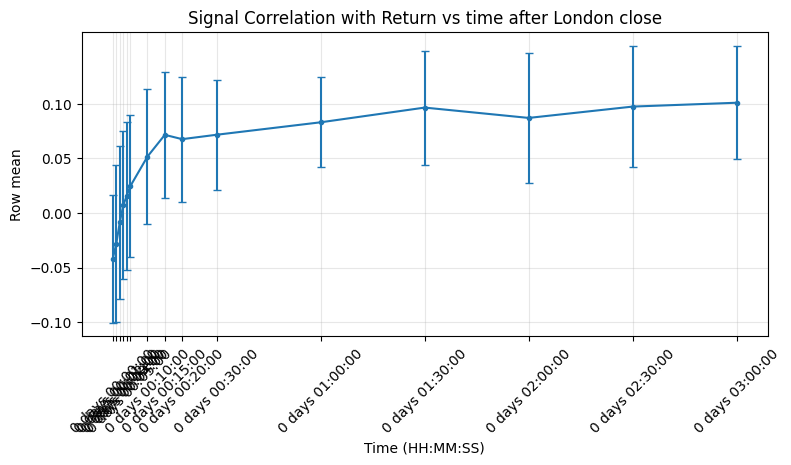

In [34]:
import seaborn as sns

df = pd.DataFrame(all_ny_ic)
df.index = t0_deltas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

# --- Assume df is your DataFrame ---
# Rows = times (TimedeltaIndex), columns = series you want to average per row
# Example dtype check (optional):
assert isinstance(df.index, pd.TimedeltaIndex), "Index must be a TimedeltaIndex"

# 1) Row-wise statistics
row_mean = df.mean(axis=1)                # average of each row
row_err  = df.std(axis=1, ddof=1)         # error bars = row-wise std
# If you prefer standard error of the mean (SEM), use:
# row_err = df.std(axis=1, ddof=1) / np.sqrt(df.shape[1])

# 2) Convert TimedeltaIndex to numeric (nanoseconds) for robust formatting
x_ns = df.index.values.astype('timedelta64[ns]').astype('int64')

# 3) Plot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
ax.errorbar(
    x_ns, row_mean.values, yerr=row_err.values,
    fmt='-o', linewidth=1.5, capsize=3, markersize=3
)

# 4) Format x-axis to show HH:MM:SS (drop fractional seconds). Adjust to taste.
def td_formatter(v, pos):
    # v is in nanoseconds
    s = str(pd.to_timedelta(int(v), unit='ns'))
    return s.split('.')[0]  # strip fractional seconds like '00:01:23.456789'

ax.xaxis.set_major_formatter(FuncFormatter(td_formatter))
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune=None))

ax.set_xlabel("Time (HH:MM:SS)")
ax.set_ylabel("Row mean")
ax.set_title("Signal Correlation with Return vs time after London close")

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.xticks(rotation=45)
plt.yticks([-0.1, -0.05, 0.0, 0.05, 0.10])
ax.set_xticks(x_ns)
ax.set_xticklabels([str(td).split('.')[0] for td in df.index])  # format HH:MM:SS
plt.show()